# Cvičení 03 — Rozšíření MLP (ReLU, Softmax, Cross-Entropy, atd.)

O co tady jde:
- toto je rozšíření předchozího cvičení dle přvní části předchozí přednášky.
  - přidány jsou aktivační funkce
  - softmax vrstva
  - rozdělení vstupních dat na testovací a trénovací množinu, možnost sledovat vývoj chyby na obojím (memorizace vs generalizace)
  - přidána ukázka klasifikace do 3 tříd (využití softmaxu)

## 0) Jupyter rychlostart (1–2 min)
- Spuštění buňky: **Shift+Enter**
- Přepnutí buňky na kód / markdown: **Y/M** (v command módu)
- Vložit buňku pod: **B**, smazat: **DD**

## 1) Knihovny a nastavení
Použijeme `numpy` a `matplotlib`. Pro dataset **Two Moons** se pokusíme použít `sklearn`, ale máme i NumPy fallback.

In [39]:
import numpy as np
import matplotlib.pyplot as plt

try:
    from sklearn.datasets import make_moons
    SKLEARN_OK = True
except Exception:
    SKLEARN_OK = False

np.set_printoptions(suppress=True, linewidth=120, precision=4)

## 2) Aktivační funkce a jejich derivace
Implementace nových aktivací: **ReLU, softplus, Leaky ReLU, Swish, ELU**.

In [42]:
class Activation:
    """ Obecná třída pro aktivační funkce s cache pro backprop. """
    def __call__(self, z):
        raise NotImplementedError
    
    def backward(self, dL_da):
        # dL/dz = dL/da * da/dz 
        return dL_da * self.da_dz

class Sigmoid(Activation):
    """ Sigmoid: a = 1 / (1 + e^-z) """
    def __call__(self, z):
        a = 1.0 / (1.0 + np.exp(-z))
        self.a = a 
        self.da_dz = a * (1.0 - a)
        return a

class ReLU(Activation):
    """ ReLU: a = max(0, z) """
    def __call__(self, z):
        a = np.maximum(0, z)
        self.da_dz = (z > 0).astype(float) # Derivace je 1 pro z > 0, 0 pro z <= 0
        return a

class LeakyReLU(Activation):
    """ Leaky ReLU: a = max(alpha * z, z), alpha = 0.01 """
    def __init__(self, alpha=0.01): self.alpha = alpha
    def __call__(self, z):
        a = np.maximum(self.alpha * z, z)
        self.da_dz = np.where(z > 0, 1.0, self.alpha)
        return a
    
class Softplus(Activation):
    """ Softplus: a = ln(1 + e^z). Derivace je Sigmoid. """
    def __call__(self, z):
        # np.log1p(x) = log(1+x)
        a = np.log1p(np.exp(z))
        self.da_dz = 1.0 / (1.0 + np.exp(-z)) # Derivace Softplus je Sigmoid
        return a
    
class Swish(Activation):
    """ Swish (SiLU): a = z * sigmoid(z) """
    def __init__(self): self.sigmoid = Sigmoid() 
    def __call__(self, z):
        a_sig = self.sigmoid(z) # Voláme Sigmoid k získání 'a' a uložení cache
        a = z * a_sig
        # Derivace: a_sig + z * a_sig * (1 - a_sig) = a_sig + a * (1 - a_sig)
        self.da_dz = a_sig + a * (1.0 - a_sig)
        return a
    
class ELU(Activation):
    """ ELU: a = z if z > 0, a = alpha * (e^z - 1) if z <= 0 """
    def __init__(self, alpha=1.0): self.alpha = alpha
    def __call__(self, z):
        a = np.where(z > 0, z, self.alpha * (np.exp(z) - 1))
        # Derivace: 1 if z > 0, a + alpha if z <= 0
        self.da_dz = np.where(z > 0, 1.0, a + self.alpha)
        return a


Tato funkce vykreslí aktivační funkci a její derivaci.

In [45]:
def plot_activation(name, activation_fn, z_values):
    """Vykreslí aktivační funkci a její derivaci."""
    
    # 1. Spočítá aktivační hodnoty 'a'. Toto volání také uloží 'da_dz' do cache instance.
    a_values = activation_fn(z_values)
    
    # 2. Načte derivaci z cache (da_dz)
    da_dz_values = activation_fn.da_dz

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{name} Activation Function and Derivative', fontsize=16)

    # Plot Activation (a)
    ax[0].plot(z_values, a_values, label=f'a = {name}(z)')
    ax[0].set_title('Activation Function (a)')
    ax[0].set_xlabel('z (Input)')
    ax[0].set_ylabel('a (Output)')
    ax[0].grid(True)
    ax[0].legend()

    # Plot Derivative (da/dz)
    ax[1].plot(z_values, da_dz_values, label=f'da/dz = {name}\'(z)', color='red')
    ax[1].set_title('Derivative (da/dz)')
    ax[1].set_xlabel('z (Input)')
    ax[1].set_ylabel('da/dz (Gradient)')
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Vytvoříme vstupní data a instance všech aktivačních funkcí.

In [48]:
# Vstupní hodnoty pro vykreslení
z = np.linspace(-5, 5, 200).reshape(-1, 1)

# Seznam aktivačních funkcí pro vykreslení
activations_to_plot = [
    ("Sigmoid", Sigmoid()),
    ("ReLU", ReLU()),
    ("LeakyReLU (alpha=0.1)", LeakyReLU(alpha=0.1)),
    ("Softplus", Softplus()),
    ("Swish", Swish()),
    ("ELU (alpha=1.0)", ELU(alpha=1.0))
]

Spustíme vykreslení pro každou aktivaci.

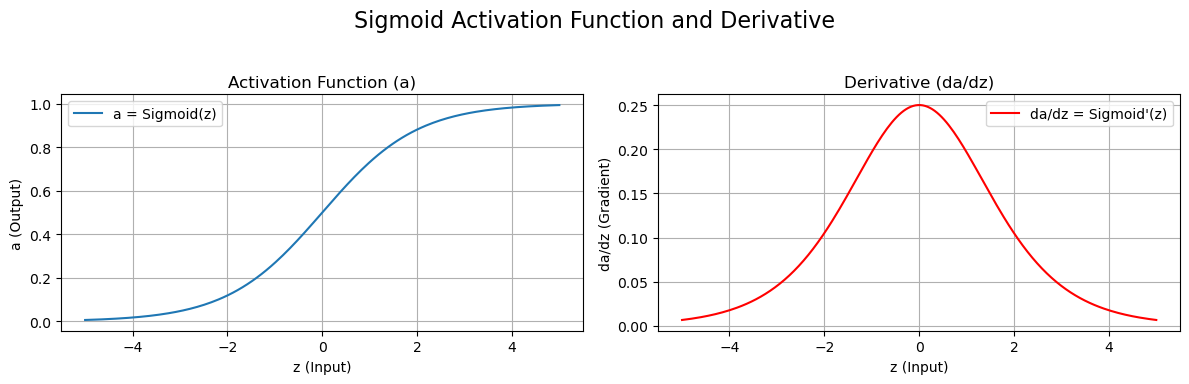

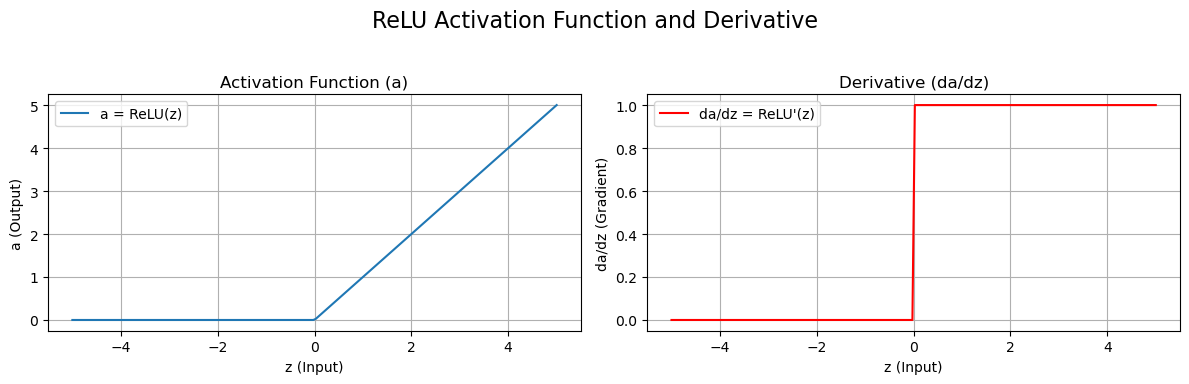

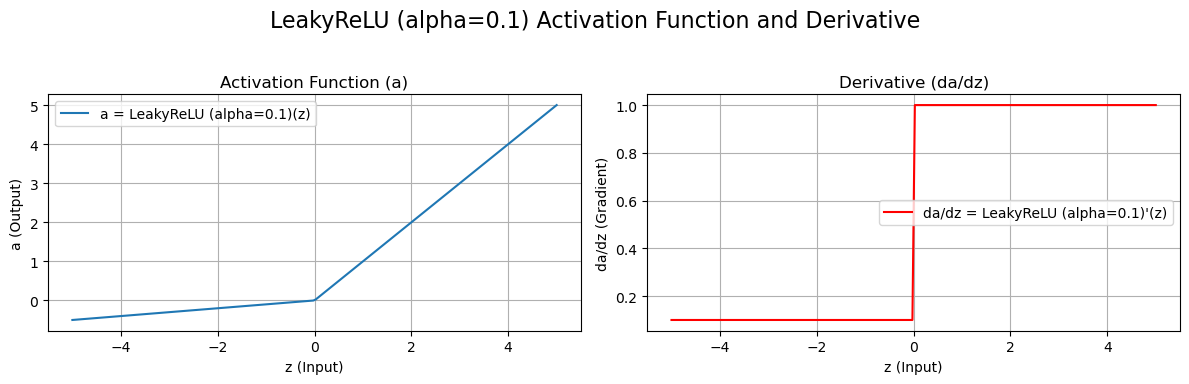

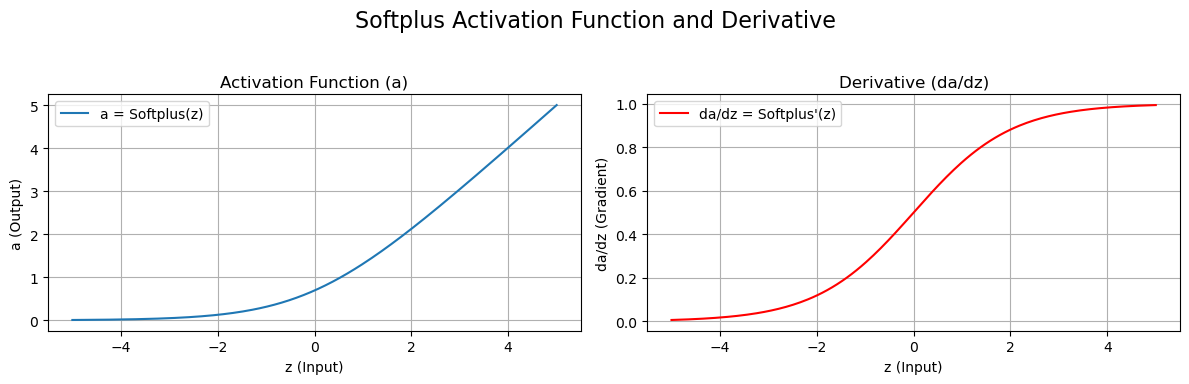

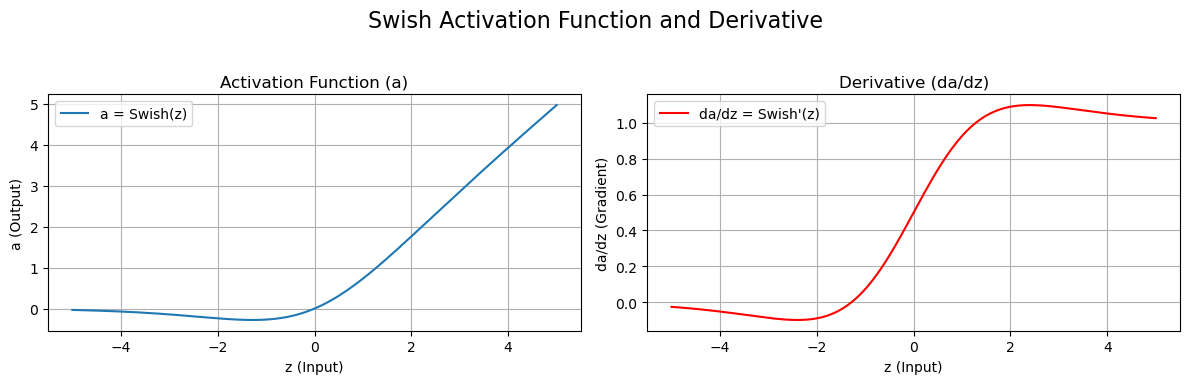

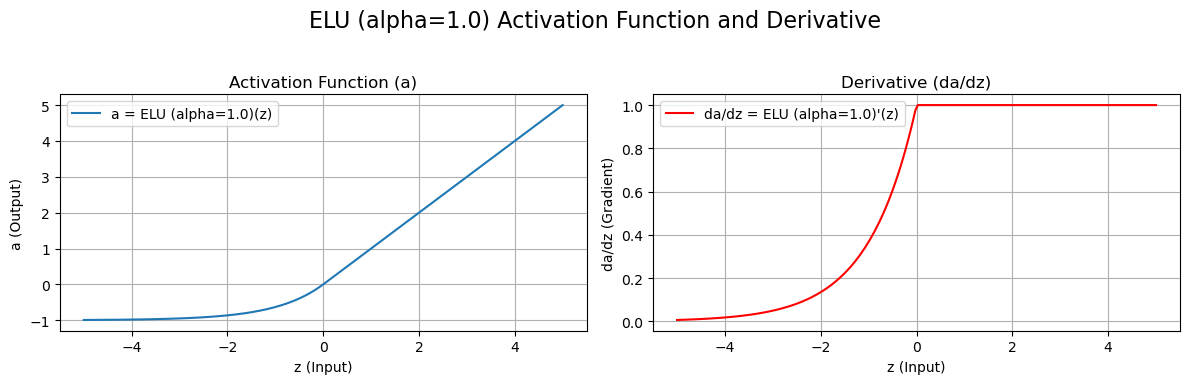

In [51]:
for name, activation_instance in activations_to_plot:
    # Pro účely vykreslení musíme vytvořit novou instanci, \
    # aby se da_dz nepřepisovalo mezi voláními
    plot_activation(name, activation_instance, z)

## 3) Ztrátové funkce a jejich derivace
Implementace **Negative Log Likelihood / Cross-Entropy** se Softmaxem (**SoftmaxCE**).

In [53]:
class LSE:  # 1/2 * (y_hat - y)^2 averaged over batch
    """ Least Squares Error (LSE) - Pro regresi nebo binární klasifikaci. """
    def __call__(self, y_pred, y_true):
        diff = y_pred - y_true
        # Průměr přes batch i výstupní dimenze, s faktorem 1/2
        loss = 0.5 * np.mean(np.sum(diff**2, axis=1))
        # dL/da = (1/B) * (y_pred - y_true) - Derivace podle výstupu sítě 'a'
        dL_da = diff / y_pred.shape[0]
        return loss, dL_da
    
class SoftmaxCE:
    """ Softmax + Cross-Entropy Loss (NLL) - Pro více-třídní klasifikaci. Vrátí dL/dz. """
    def __call__(self, z_pred, y_true):
        # --- Forward: Softmax + Cross-Entropy ---
        # 1. Numericky stabilní Softmax (přes dimenzi tříd)
        exp_z = np.exp(z_pred - np.max(z_pred, axis=1, keepdims=True))
        y_pred = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        
        # 2. Cross-Entropy Loss (y_true je one-hot)
        y_pred_clipped = np.clip(y_pred, 1e-12, 1.0 - 1e-12)
        loss = - np.mean(np.sum(y_true * np.log(y_pred_clipped), axis=1))
        
        # --- Backward: dL/dz ---
        # Zjednodušený gradient: dL/dz = y_pred - y_true (průměrovaný přes batch)
        # Backpropagation začíná od dL/dz.
        dL_dz = (y_pred - y_true) / y_pred.shape[0]
        
        # Pro účely predikce a přesnosti uložíme y_pred
        self.y_pred = y_pred
        
        return loss, dL_dz


## 4) Vrstvy MLP a Xavier inicializace
Úprava `Dense` vrstvy pro podporu obecné třídy `Activation` a backpropagationu z Loss funkcí vracejících \(\partial L/\partial z\).

In [55]:
class Dense:
    def __init__(self, in_dim, out_dim, activation=None):
        # Xavier-like init (pro sigmoid/tanh)
        limit = np.sqrt(1.0 / in_dim)
        self.W = np.random.uniform(-limit, limit, (in_dim, out_dim))
        self.b = np.zeros((1, out_dim))
        self.activation = activation
        # cache
        self.x = None; self.z = None; self.a = None
        # grads
        self.dW = np.zeros_like(self.W); self.db = np.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        self.z = x @ self.W + self.b
        if self.activation is None:
            self.a = self.z # Lineární výstup (logity 'z')
        else:
            self.a = self.activation(self.z)
        return self.a

    def backward(self, dL_d_output):
        # dL_d_output: dL/da z další vrstvy NEBO dL/dz z Loss (SoftmaxCE)
        
        # Kontrola, zda dL_d_output není z Loss funkce SoftmaxCE (která vrací dL/dz)
        # (SoftmaxCE je implementována tak, že vrací gradient jako np.ndarray, ale je potřeba vědět, zda je již dL/dz)
        # Zde předpokládáme, že pokud poslední vrstva nemá aktivaci a Loss vrací dL/dz (což je případ SoftmaxCE v MLP), 
        # pak je dL_d_output již dL/dz.
        is_loss_dz = not isinstance(self.activation, Activation) and dL_d_output.ndim == self.z.ndim
        
        if is_loss_dz or self.activation is None:
            dL_dz = dL_d_output
        else:
            # Vrstva s aktivací NEBO poslední vrstva s LSE
            dL_dz = self.activation.backward(dL_d_output)

        # Spočítáme gradienty pro parametry W a b (průměrované přes batch)
        self.dW = self.x.T @ dL_dz / self.x.shape[0]
        self.db = np.mean(dL_dz, axis=0, keepdims=True)
        
        # Gradient pro předchozí vrstvu
        dL_dx = dL_dz @ self.W.T
        return dL_dx

    def step(self, lr):
        self.W -= lr * self.dW
        self.b -= lr * self.db

## 5) Model `MLP` a trénování
Úprava `MLP` pro volbu Loss funkce a metodu `predict` pro SoftmaxCE.
Navíc metoda `train` přijímá data pro testovací sadu, a počítá na ní chybu po každé epoše.

In [60]:
class MLP:
    def __init__(self, layers, loss):
        self.layers = layers
        self.loss = loss
        self.loss_includes_activation = isinstance(loss, SoftmaxCE)

    def forward(self, x):
        a = x
        for layer in self.layers:
            a = layer.forward(a)
        # Pokud SoftmaxCE, vracíme logity 'z' pro výpočet Loss
        return a 

    def predict(self, X):
        # Vždy chceme pravděpodobnosti nebo finální reg. výstup.
        y_raw = self.forward(X)
        if self.loss_includes_activation:
            # Aplikujeme Softmax na logity 'z'
            exp_z = np.exp(y_raw - np.max(y_raw, axis=1, keepdims=True))
            return exp_z / np.sum(exp_z, axis=1, keepdims=True)
        else:
            return y_raw

    def backward(self, dL_d_output):
        g = dL_d_output
        for layer in reversed(self.layers):
            g = layer.backward(g)

    def step(self, lr):
        for layer in self.layers:
            layer.step(lr)

    def train(self, X, Y, X_val=None, Y_val=None, lr=0.1, epochs=2000, batch_size=None, verbose=False):
        train_losses = []
        val_losses = []
        n = X.shape[0]
        
        has_val_data = X_val is not None and Y_val is not None

        for ep in range(epochs):
            # --- Trénovací fáze (s aktualizací vah) ---
            if batch_size is None or batch_size >= n:
                idx = np.arange(n)
            else:
                idx = np.random.permutation(n)

            ep_loss = 0.0; batches = 0
            for start in range(0, n, batch_size or n):
                end = min(start + (batch_size or n), n)
                bidx = idx[start:end]
                xb, yb = X[bidx], Y[bidx]

                y_raw = self.forward(xb)
                loss, dL_d_output = self.loss(y_raw, yb)
                self.backward(dL_d_output)
                self.step(lr)

                ep_loss += loss; batches += 1

            train_losses.append(ep_loss / max(1, batches))

            # --- Validační fáze (pouze výpočet ztráty, bez aktualizace vah) ---
            if has_val_data:
                y_val_raw = self.forward(X_val)
                val_loss, _ = self.loss(y_val_raw, Y_val)
                val_losses.append(val_loss)
            
            if verbose and (ep+1) % max(1, epochs//10) == 0:
                val_output = f" | val_loss={val_losses[-1]:.6f}" if has_val_data else ""
                print(f"epoch {ep+1}/{epochs} | loss={train_losses[-1]:.6f}{val_output}")
                
        return np.array(train_losses), np.array(val_losses)

## 6) Vizualizace — křivka ztráty a rozhodovací hranice
Používá `MLP.predict` pro správnou predikci i v případě SoftmaxCE.

In [63]:
def train_test_split(X, Y, test_size=0.2, seed=42):
    """Rozdělí data na trénovací a testovací množinu."""
    np.random.seed(seed)
    n = X.shape[0]
    n_test = int(n * test_size)
    idx = np.random.permutation(n)
    
    test_idx = idx[:n_test]
    train_idx = idx[n_test:]
    
    return X[train_idx], X[test_idx], Y[train_idx], Y[test_idx]


def plot_loss(train_losses, val_losses=None, title="Průběh ztráty (Loss)"):
    """Vykreslí trénovací a testovací ztrátu v jednom grafu."""
    plt.figure(); 
    plt.plot(train_losses, label='Trénovací ztráta (Train Loss)')
    
    if val_losses is not None and len(val_losses) > 0:
        plt.plot(val_losses, label='Testovací ztráta (Test/Validation Loss)')
    
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(title); plt.legend(); plt.show()

def plot_decision_boundary_2d(model, X, Y, title="Rozhodovací hranice"):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    with np.errstate(over='ignore'):
        zz = model.predict(grid)
        
    # Zpracování výstupu pro rozhodovací hranici
    if zz.ndim == 2 and zz.shape[1] == 1:
        # Binární klasifikace s jedním výstupem (např. LSE + Sigmoid)
        zz = (zz >= 0.5).astype(int)
    elif zz.ndim == 2 and zz.shape[1] > 1:
        # Více-třídní klasifikace (např. SoftmaxCE) - argmax z pravděpodobností
        zz = np.argmax(zz, axis=1)
    else:
        # Regrese nebo jiné případy
        return
    
    zz = zz.reshape(xx.shape)
    plt.figure(); plt.contourf(xx, yy, zz, alpha=0.25, levels=2)
    
    # Nastavení barvy pro Y (konverze one-hot na indexy)
    if Y.ndim == 2 and Y.shape[1] > 1:
        c = np.argmax(Y, axis=1) # Pro one-hot kódování
    elif Y.ndim == 2 and Y.shape[1] == 1:
        c = Y.ravel()
    else: c = Y
        
    plt.scatter(X[:,0], X[:,1], c=c, edgecolors="k")
    plt.title(title); plt.xlabel("x1"); plt.ylabel("x2"); plt.show()

def plot_regression_1d(model, Xr, Yr, title="Regrese: sin(2πx)"):
    xs = np.linspace(-1.2, 1.2, 400).reshape(-1,1)
    ys = model.predict(xs)
    plt.figure()
    plt.scatter(Xr, Yr, s=10, alpha=0.6, label="data")
    plt.plot(xs, np.sin(2*np.pi*xs), linestyle="--", label="sin(2πx) — ground truth")
    plt.plot(xs, ys, label="MLP predikce")
    plt.legend(); plt.title(title); plt.xlabel("x"); plt.ylabel("y"); plt.show()

# 7) Úloha A — **XOR** s **ReLU** a **LSE**
Vyzkoušíme XOR s novou aktivací **ReLU** (2-2-1 síť, LSE ztráta). Výstupní vrstva musí používat Sigmoid pro binární klasifikaci, aby byl LSE srozumitelný.

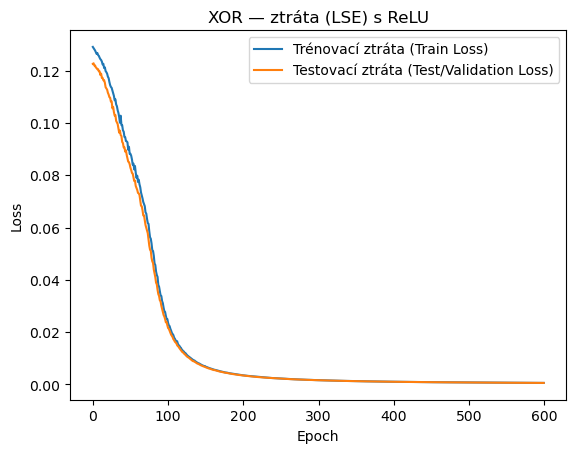

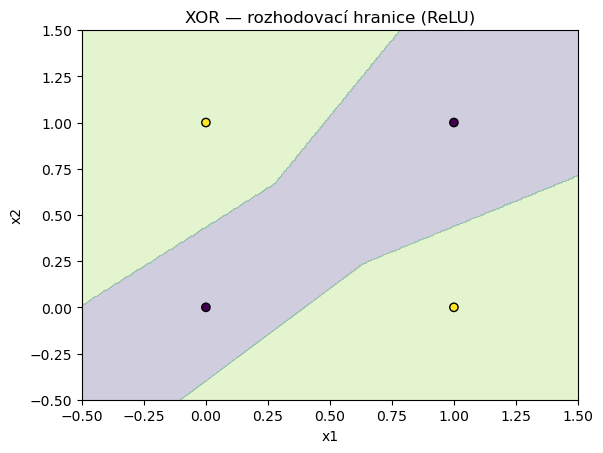

Predikce XOR (na celé sadě): [0.056 0.976 0.98  0.018]


In [70]:
# XOR data
X_xor = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
Y_xor = np.array([[0],[1],[1],[0]], dtype=float)

# Rozdělení dat: U XOR je trénovací sada shodná s testovací (symbolické použití)
X_train, X_test, Y_train, Y_test = X_xor, X_xor, Y_xor, Y_xor

np.random.seed(0)
xor_net = MLP(
    layers=[Dense(2, 4, ReLU()), Dense(4, 1, Sigmoid())],
    loss=LSE()
)
losses_train_xor, losses_val_xor = xor_net.train(X_train, Y_train, 
                                                 X_val=X_test, Y_val=Y_test, 
                                                 lr=0.5, epochs=600, batch_size=1, verbose=False)

plot_loss(losses_train_xor, losses_val_xor, title="XOR — ztráta (LSE) s ReLU")

plot_decision_boundary_2d(xor_net, X_xor, Y_xor, title="XOR — rozhodovací hranice (ReLU)")
print("Predikce XOR (na celé sadě):", np.round(xor_net.predict(X_xor), 3).ravel())


## 8) Úloha B — **Two Moons** s **SoftmaxCE** a **Swish** aktivací
Více-třídní klasifikace (i když jen 2 třídy), kde použijeme **SoftmaxCE** ztrátu a aktivaci **Swish**.

Všimněte si jak se vyvíjí testovací a trénovací chyba.

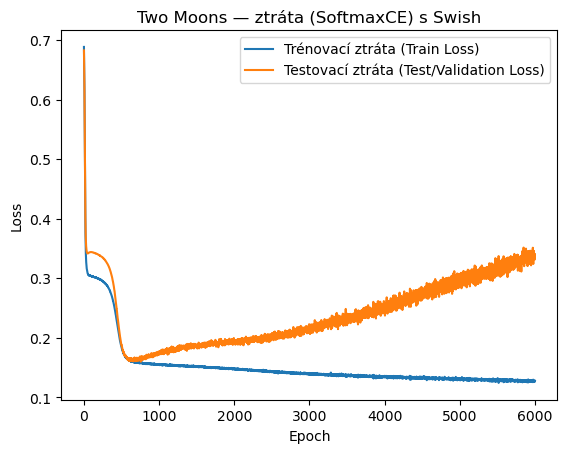

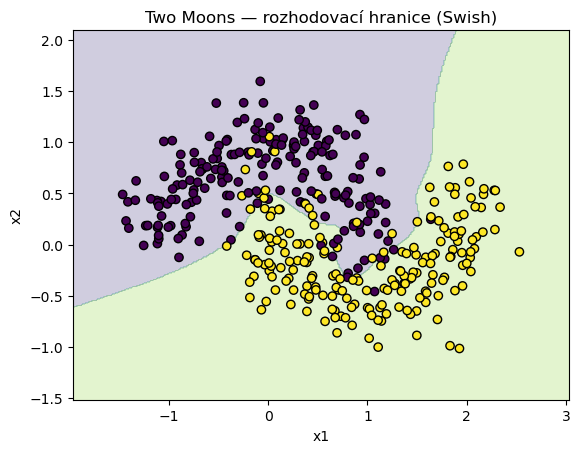

Přibližná testovací přesnost: 90.0%


In [76]:
def make_moons_np(n_samples=200, noise=0.1, seed=42):
    rng = np.random.default_rng(seed)
    n = n_samples // 2
    t1 = rng.uniform(0, np.pi, n)
    x1 = np.c_[np.cos(t1), np.sin(t1)] + rng.normal(scale=noise, size=(n,2))
    t2 = rng.uniform(0, np.pi, n)
    x2 = np.c_[1 - np.cos(t2), 1 - np.sin(t2) - 0.5] + rng.normal(scale=noise, size=(n,2))
    X = np.vstack([x1, x2]); y = np.vstack([np.zeros((n,1)), np.ones((n,1))])
    idx = rng.permutation(X.shape[0]); return X[idx], y[idx]

if SKLEARN_OK:
    X_moons, y_moons = make_moons(n_samples=400, noise=0.25, random_state=0)
    # Konverze labelů na one-hot encoding (2 třídy)
    ohe = OneHotEncoder(sparse_output=False); 
    Y_moons_ohe = ohe.fit_transform(y_moons.reshape(-1,1))
else:
    X_moons, y_moons = make_moons_np(n_samples=400, noise=0.25, seed=0)
    # Manuální konverze labelů na one-hot encoding (2 třídy)
    Y_moons_ohe = np.zeros((y_moons.size, 2))
    Y_moons_ohe[np.arange(y_moons.size), y_moons.ravel().astype(int)] = 1

# Rozdělení dat
X_train, X_test, Y_train_ohe, Y_test_ohe = train_test_split(X_moons, Y_moons_ohe, test_size=0.3, seed=42)
y_test_labels = np.argmax(Y_test_ohe, axis=1) # Pro přesnost testu

np.random.seed(1)
moons_net = MLP(
    layers=[Dense(2, 16, Swish()), Dense(16, 16, Swish()), Dense(16, 2, None)],
    loss=SoftmaxCE()
)
losses_train_moons, losses_val_moons = moons_net.train(X_train, Y_train_ohe, 
                                                       X_val=X_test, Y_val=Y_test_ohe, 
                                                       lr=0.1, epochs=6000, batch_size=8, verbose=False)

plot_loss(losses_train_moons, losses_val_moons, title="Two Moons — ztráta (SoftmaxCE) s Swish")
plot_decision_boundary_2d(moons_net, X_moons, Y_moons_ohe, title="Two Moons — rozhodovací hranice (Swish)")

# Přesnost na testovací sadě
pred_test = np.argmax(moons_net.predict(X_test), axis=1)
acc_test = (pred_test == y_test_labels).mean()*100
print(f"Přibližná testovací přesnost: {acc_test:.1f}%")



## 9) Úloha C — **1D regrese** (sinus) s **ELU** aktivací a **LSE**
Regrese má lineární výstup. Síť aproximuje \(\sin(2\pi x)\) se šumem pomocí LSE. Použijeme **ELU** pro skryté vrstvy.

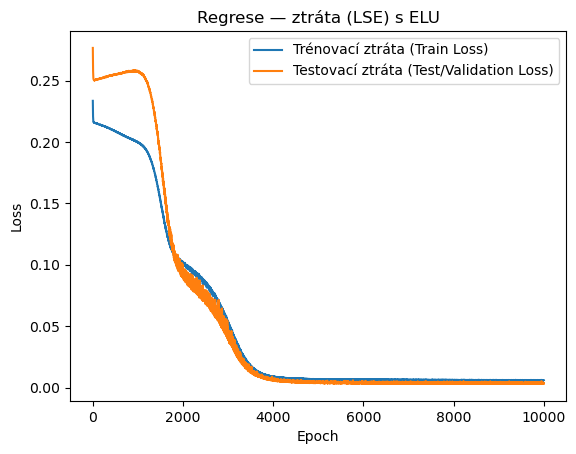

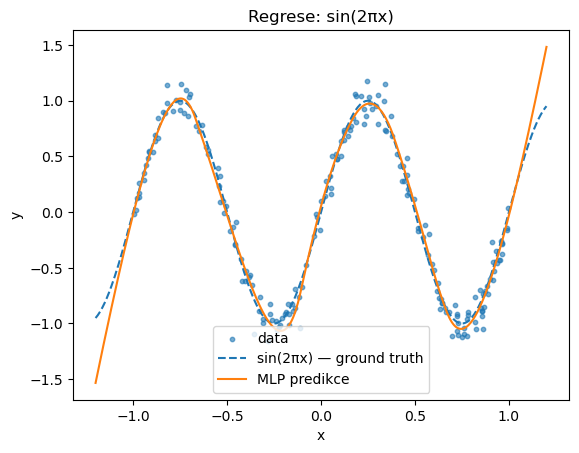

Regrese dokončena.


In [80]:
rng = np.random.default_rng(0)
Xr = rng.uniform(-1.0, 1.0, size=(200,1))
Yr = np.sin(2*np.pi*Xr) + rng.normal(scale=0.1, size=(200,1))

# Rozdělení dat pro regresi
Xr_train, Xr_test, Yr_train, Yr_test = train_test_split(Xr, Yr, test_size=0.2, seed=42)

np.random.seed(2)
reg_net = MLP(
    layers=[Dense(1, 32, ELU()), Dense(32, 32, ELU()), Dense(32, 1, None)],
    loss=LSE()
)
losses_train_reg, losses_val_reg = reg_net.train(Xr_train, Yr_train, 
                                                 X_val=Xr_test, Y_val=Yr_test, 
                                                 lr=0.01, epochs=1000, batch_size=4, verbose=False)
                                                 
plot_loss(losses_train_reg, losses_val_reg, title="Regrese — ztráta (LSE) s ELU")
plot_regression_1d(reg_net, Xr, Yr)
print("Regrese dokončena.")

## 10) Úloha D — Více-třídní klasifikace na **Iris** s **SoftmaxCE** a **Leaky ReLU**
Klasifikace na 3 třídy (Setosa, Versicolor, Virginica) s 4 vstupními znaky.


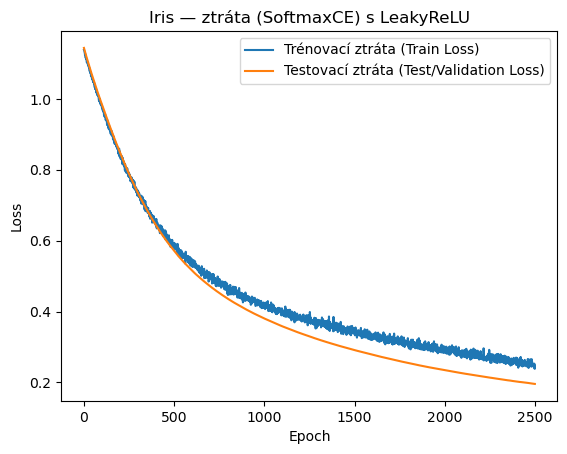

Přibližná testovací přesnost: 96.7%


In [96]:
def load_iris_data():
    # Použijeme sklearn pro snadné načtení dat Iris. Pokud není, nelze spustit.
    if not SKLEARN_OK:
        print("Sklearn není k dispozici, nelze načíst dataset Iris.")
        return None, None, None
    
    from sklearn.datasets import load_iris
    from sklearn.preprocessing import StandardScaler
    
    data = load_iris()
    X = data.data.astype(np.float32)
    y = data.target.astype(np.int32)
    
    # Normalizace dat (důležité pro hluboké sítě)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Konverze labelů na One-Hot Encoding (3 třídy)
    ohe = OneHotEncoder(sparse_output=False);
    Y_ohe = ohe.fit_transform(y.reshape(-1, 1))
    
    return X, y, Y_ohe

X_iris, y_iris, Y_iris_ohe = load_iris_data()

if X_iris is not None:
    # Rozdělení dat
    X_train, X_test, Y_train_ohe, Y_test_ohe = train_test_split(X_iris, Y_iris_ohe, test_size=0.2, seed=42)
    # Získání skutečných labelů pro výpočet přesnosti
    y_test_labels = np.argmax(Y_test_ohe, axis=1)
    
    # Architektura 4 vstupní znaky -> 10 neuronů (LeakyReLU) -> 3 výstupní třídy (logity)
    np.random.seed(42)
    iris_net = MLP(
        layers=[
            Dense(4, 10, LeakyReLU(alpha=0.05)), 
            Dense(10, 3, None) # Poslední vrstva vrací logity 'z'
        ],
        loss=SoftmaxCE()
    )
    
    # Trénování
    losses_train_iris, losses_val_iris = iris_net.train(X_train, Y_train_ohe, 
                                                        X_val=X_test, Y_val=Y_test_ohe, 
                                                        lr=0.01, epochs=2500, batch_size=16, verbose=False)

    plot_loss(losses_train_iris, losses_val_iris, title="Iris — ztráta (SoftmaxCE) s LeakyReLU")
    
    # Přesnost na testovací sadě
    pred_test = np.argmax(iris_net.predict(X_test), axis=1)
    acc_test = (pred_test == y_test_labels).mean()*100
    print(f"Přibližná testovací přesnost: {acc_test:.1f}%")

U předchozího není vykreslena rozhodovací hranice, protože vstupní prostor je 4d.

Níže je totéž, ale síť je učena na PCA redukci vstupního prostoru na 2 dimenze.

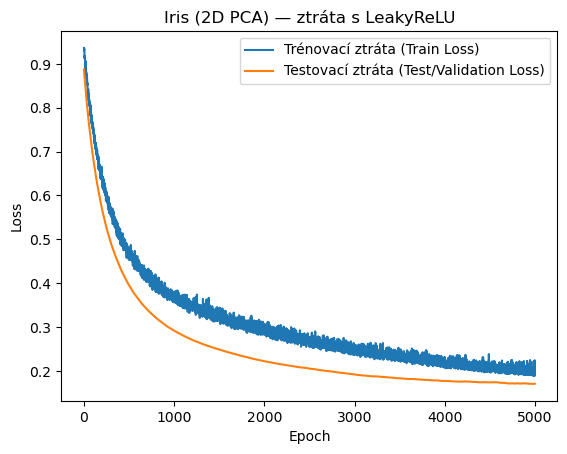

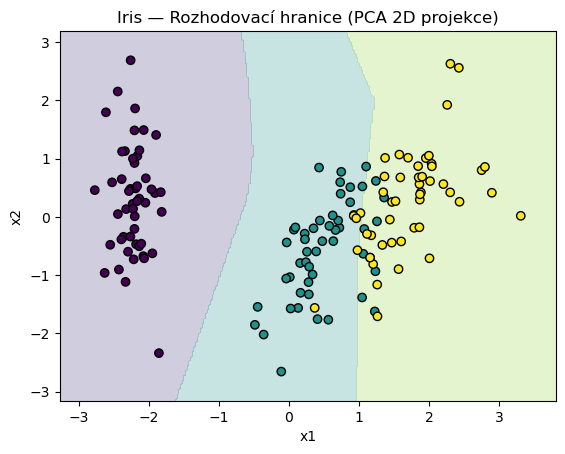

Přibližná testovací přesnost na 2D PCA datech: 90.0%


In [100]:
if SKLEARN_OK and X_iris is not None:
    from sklearn.decomposition import PCA
    
    # 1. Trénování a transformace PCA na celé sadě
    pca = PCA(n_components=2)
    X_iris_2d = pca.fit_transform(X_iris)
    
    # 2. Rozdělení 2D dat pro trénink (Y_iris_ohe zůstává 3D one-hot)
    X_train_2d, X_test_2d, Y_train_ohe_2d, Y_test_ohe_2d = train_test_split(X_iris_2d, Y_iris_ohe, test_size=0.2, seed=42)
    y_test_labels_2d = np.argmax(Y_test_ohe_2d, axis=1)

    # 3. Inicializace NOVÉ 2D SÍTĚ (Vstupní dimenze je 2)
    np.random.seed(42) 
    iris_net_2d = MLP(
        layers=[
            Dense(2, 10, LeakyReLU(alpha=0.05)),  # ZMĚNA: INPUT DIMENSION = 2
            Dense(10, 3, None) 
        ],
        loss=SoftmaxCE()
    )
    
    # 4. Trénování NOVÉ 2D SÍTĚ na 2D PCA datech
    losses_train_2d, losses_val_2d = iris_net_2d.train(X_train_2d, Y_train_ohe_2d, 
                                                       X_val=X_test_2d, Y_val=Y_test_ohe_2d, 
                                                       lr=0.01, epochs=5000, batch_size=16, verbose=False)
                                                       
    # 5. Vizualizace
    plot_loss(losses_train_2d, losses_val_2d, title="Iris (2D PCA) — ztráta s LeakyReLU")
    
    # Vykreslení rozhodovací hranice pro 2D PCA data pomocí NOVÉ 2D sítě
    plot_decision_boundary_2d(iris_net_2d, X_iris_2d, Y_iris_ohe, 
                              title="Iris — Rozhodovací hranice (PCA 2D projekce)")
    
    # Přesnost na 2D testovací sadě
    pred_test_2d = np.argmax(iris_net_2d.predict(X_test_2d), axis=1)
    acc_test_2d = (pred_test_2d == y_test_labels_2d).mean()*100
    
    print(f"Přibližná testovací přesnost na 2D PCA datech: {acc_test_2d:.1f}%")
else:
    print("Nelze provést vizualizaci PCA, chybí dataset Iris nebo sklearn.")